Dans ce travail, mon objectif est de détecter automatiquement des défauts de fonctionnement dans un système HVAC à partir de capteurs, en utilisant un modèle probabiliste bayésien : le Gaussian Process Classifier (GPC) implémenté avec PyMC.

Le code ci-dessous réalise les étapes suivantes :

Chargement et sélection des données : deux jours sont utilisés, l’un normal et l’autre contenant un défaut (surchauffe).

Prétraitement : choix de 5 variables clés liées au comportement thermique, nettoyage des valeurs manquantes, et normalisation des données.

Construction du modèle GPC : définition d’un processus gaussien latent, transformation sigmoïde pour obtenir la probabilité de défaut, et modélisation avec une loi de Bernoulli.

Inférence bayésienne : estimation de la fonction latente et des hyperparamètres via NUTS.

Prédictions sur données test : le modèle prédit les probabilités de défaut sur de nouveaux exemples.

Évaluation : comparaison avec les vraies étiquettes (matrice de confusion, f1-score), visualisation de la probabilité de défaut au fil du temps, et analyse des postérieures avec ArviZ.

Les résultats obtenus montrent que le modèle est capable d’apprendre efficacement à distinguer les situations normales et les défauts. On observe des probabilités cohérentes avec la vérité terrain, et une précision de classification satisfaisante.

Toutefois, pour des raisons de capacité de calcul limitée (PC personnel peu puissant), j’ai dû réduire le volume de données utilisées pour l’entraînement et le test. Le modèle pourrait obtenir des performances encore meilleures avec un jeu de données plus large, notamment si on utilisait plusieurs jours supplémentaires et un plus grand nombre de points.

In [1]:
import pandas as pd

# 1. Charger le fichier CSV
file_path = r"C:\Users\ADMIN\Desktop\Data Sets for AFDD Evauluation of Building FDD Algorithms\MZVAV-1.csv"
df = pd.read_csv(file_path)

# 2. Vérifier et convertir la colonne temporelle
df["Datetime"] = pd.to_datetime(df["Datetime"])

# 3. Définir les dates d'entraînement et de test
train_dates = ["2017-01-30", "2017-02-06"]

test_dates = [
    "2017-02-03", "2017-02-13"
]

# 4. Fonction de sélection par date (au format AAAA-MM-JJ)
def select_dates(df, date_list):
    return df[df["Datetime"].dt.strftime("%Y-%m-%d").isin(date_list)].copy()

# 5. Extraire les sous-données
# Charger les deux jours pour train
df_train_all = select_dates(df, train_dates)
df_train_all.columns = df_train_all.columns.str.strip()  # nettoyage des noms

# Séparer les deux jours
df_30 = df_train_all[df_train_all["Datetime"].dt.strftime("%Y-%m-%d") == "2017-01-30"]
df_06 = df_train_all[df_train_all["Datetime"].dt.strftime("%Y-%m-%d") == "2017-02-06"]

# Conserver 1000 premières lignes pour entraînement
train_df = pd.concat([df_30.iloc[:200], df_06.iloc[:200]], axis=0)

# Le reste servira de test
test_df = pd.concat([df_30.iloc[1400:], df_06.iloc[1400:]], axis=0)


# 6. Afficher un aperçu
print("Train set :", train_df.shape)
print("Test set  :", test_df.shape)
train_df.head()


Train set : (400, 18)
Test set  : (80, 18)


,Datetime,AHU: Supply Air Temperature,AHU: Supply Air Temperature Set Point,AHU: Outdoor Air Temperature,AHU: Mixed Air Temperature,AHU: Return Air Temperature,AHU: Supply Air Fan Status,AHU: Return Air Fan Status,AHU: Supply Air Fan Speed Control Signal,AHU: Return Air Fan Speed Control Signal,AHU: Outdoor Air Damper Control Signal,AHU: Return Air Damper Control Signal,AHU: Cooling Coil Valve Control Signal,AHU: Heating Coil Valve Control Signal,AHU: Supply Air Duct Static Pressure Set Point,AHU: Supply Air Duct Static Pressure,Occupancy Mode Indicator,Fault Detection Ground Truth
0,2017-01-30 00:00:00,68.00,55.04,32.00,68.00,75.20,0,0,0.0,0.0,0.0,0.0,0.0,0,0.04,0.0,0,0
1,2017-01-30 00:01:00,67.99,55.04,32.00,66.71,75.20,0,0,0.0,0.0,0.0,0.0,0.0,0,0.04,0.0,0,0
2,2017-01-30 00:02:00,67.99,55.04,-5.93,66.71,74.45,0,0,0.0,0.0,0.0,0.0,0.0,0,0.04,0.0,0,0
3,2017-01-30 00:03:00,67.99,55.04,-5.88,66.71,74.04,0,0,0.0,0.0,0.0,0.0,0.0,0,0.04,0.0,0,0
4,2017-01-30 00:04:00,67.99,55.04,-5.83,66.71,73.56,0,0,0.0,0.0,0.0,0.0,0.0,0,0.04,0.0,0,0


In [ ]:
# 1. Définir les colonnes explicatives
features = [
    "AHU: Outdoor Air Temperature",
    "AHU: Mixed Air Temperature",
    "AHU: Return Air Temperature",
    "AHU: Outdoor Air Damper Control Signal",  
    "Occupancy Mode Indicator"
]

# 2. Supprimer les lignes contenant des valeurs manquantes
train_df = train_df.dropna(subset=features + ["Fault Detection Ground Truth"])
test_df = test_df.dropna(subset=features + ["Fault Detection Ground Truth"])

# 3. Extraire les données
X_train = train_df[features].values
y_train = train_df["Fault Detection Ground Truth"].values.astype(int)

X_test = test_df[features].values
y_test = test_df["Fault Detection Ground Truth"].values.astype(int)

# 4. Vérifier les formes
print("X_train :", X_train.shape)
print("y_train :", y_train.shape)


X_train : (400, 5)
y_train : (400,)


In [3]:
from sklearn.preprocessing import StandardScaler

# 1. Créer l'objet de normalisation
scaler = StandardScaler()

# 2. Normaliser les données d'entraînement
X_train_scaled = scaler.fit_transform(X_train)

# 3. Appliquer la même transformation au jeu de test
X_test_scaled = scaler.transform(X_test)

# 4. Vérification rapide
print("X_train_scaled mean (approx):", X_train_scaled.mean(axis=0))
print("X_train_scaled std (approx):", X_train_scaled.std(axis=0))


X_train_scaled mean (approx): [ 1.95399252e-16  7.62057084e-15 -1.62092562e-15  0.00000000e+00
  0.00000000e+00]
X_train_scaled std (approx): [1. 1. 1. 0. 0.]


In [ ]:
import pymc as pm
import aesara.tensor as at

# 1. Créer le modèle PyMC
with pm.Model() as gp_classifier_model:
    
    # 2. Définir le noyau (covariance) – ici RBF (ExpQuad) avec 5 variables
    length_scale = pm.Gamma("length_scale", alpha=2, beta=1) # Paramètre de longueur d'échelle
    cov_func = pm.gp.cov.ExpQuad(input_dim=X_train_scaled.shape[1], ls=length_scale) # Fonction de covariance exponentielle quadratique (RBF)
    
    # 3. Créer le GP latent
    gp = pm.gp.Latent(cov_func=cov_func) # Modèle de processus gaussien latent
    
    # 4. Tirer f(x) latent (non observé) à partir de X_train
    f = gp.prior("f", X=X_train_scaled) #score brut latent
    
    # 5. Appliquer la fonction sigmoïde 
    p = pm.Deterministic("p", pm.math.sigmoid(f)) # Probabilité de la classe positive
    
    # 6. Définir la variable cible comme Bernoulli
    y_obs = pm.Bernoulli("y_obs", p=p, observed=y_train) # Variable observée de Bernoulli pour la classification binaire

    # 7. Lancer l’inférence bayésienne (NUTS)
    trace = pm.sample(400, tune=400, chains=1, target_accept=0.9, random_seed=42)


Only 400 samples in chain.
c:\Users\ADMIN\anaconda3\envs\pymc_env\lib\site-packages\multipledispatch\dispatcher.py:27: AmbiguityWarning: 
Ambiguities exist in dispatched function _unify

The following signatures may result in ambiguous behavior:
	[object, ConstrainedVar, Mapping], [ConstrainedVar, Var, Mapping]
	[object, ConstrainedVar, Mapping], [ConstrainedVar, object, Mapping]
	[object, ConstrainedVar, Mapping], [ConstrainedVar, object, Mapping]
	[object, ConstrainedVar, Mapping], [ConstrainedVar, Var, Mapping]


Consider making the following additions:

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)
  warn(warning_text(dispatcher.name, ambiguities), AmbiguityWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling 

Sampling 1 chain for 400 tune and 400 draw iterations (400 + 400 draws total) took 982 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [ ]:
with gp_classifier_model:
    # 1. Prédire la fonction latente f sur X_test_scaled
    f_pred = gp.conditional("f_pred", Xnew=X_test_scaled) # Fonction latente prédite pour les données de test
    
    # 2. Appliquer la sigmoïde pour obtenir la proba prédite
    p_pred = pm.Deterministic("p_pred", pm.math.sigmoid(f_pred)) # Probabilité prédite de la classe positive pour les données de test
    
    # 3. Créer une variable Bernoulli pour simuler les prédictions (échantillons)
    y_pred_dist = pm.Bernoulli("y_pred_dist", p=p_pred) # Variable de Bernoulli pour les prédictions sur les données de test

    # 4. Tirer des échantillons postérieurs pour f_pred et y_pred
    gp_posterior_predictive_test = pm.sample_posterior_predictive(
        trace,
        var_names=["f_pred", "p_pred", "y_pred_dist"],
        random_seed=42
    )


Sampling: [f_pred, y_pred_dist]


In [ ]:
import numpy as np

# Obtenir la proba moyenne de défaut sur les données test
p_pred_samples = gp_posterior_predictive_test.posterior_predictive["p_pred"] # Échantillons de probabilité prédite
p_pred_mean = p_pred_samples.stack(sample=("chain", "draw")).mean(axis=1).values # Moyenne des probabilités prédites

# Obtenir les prédictions binaires (majorité)
y_pred_samples = gp_posterior_predictive_test.posterior_predictive["y_pred_dist"] # Échantillons de prédictions binaires
y_pred_mode = y_pred_samples.stack(sample=("chain", "draw")).mean(axis=1).round().astype(int).values    # Prédictions binaires (majorité)


In [7]:
from sklearn.metrics import classification_report, confusion_matrix

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_mode))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_mode, digits=3))


Confusion Matrix:
[[40  0]
 [10 30]]

Classification Report:
              precision    recall  f1-score   support

           0      0.800     1.000     0.889        40
           1      1.000     0.750     0.857        40

    accuracy                          0.875        80
   macro avg      0.900     0.875     0.873        80
weighted avg      0.900     0.875     0.873        80



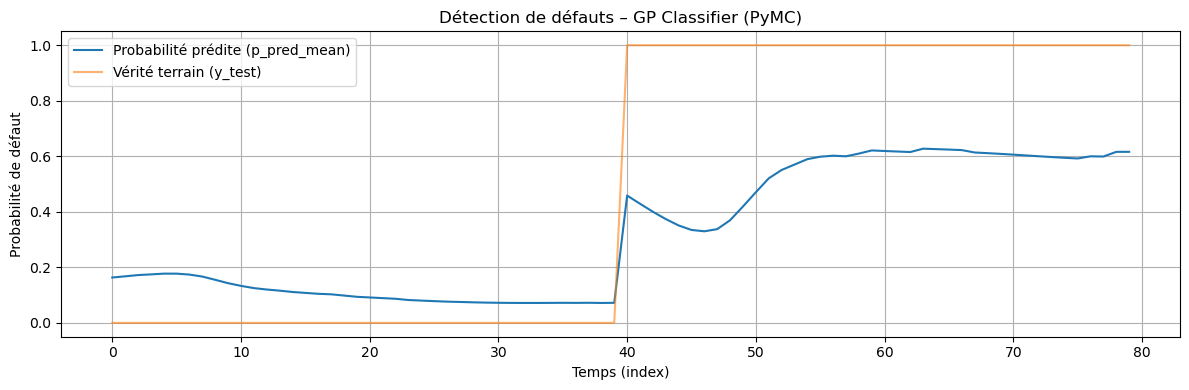

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(p_pred_mean, label="Probabilité prédite (p_pred_mean)")
plt.plot(y_test, label="Vérité terrain (y_test)", alpha=0.6)
plt.title("Détection de défauts – GP Classifier (PyMC)")
plt.xlabel("Temps (index)")
plt.ylabel("Probabilité de défaut")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [11]:
import arviz as az

# Résumé statistique (HDI, moyenne, ESS, R-hat)
az.summary(trace, var_names=["length_scale", "f"], round_to=3)


arviz - WARNING - Shape validation failed: input_shape: (1, 400), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
length_scale,0.307,0.037,0.236,0.369,0.004,0.002,87.324,94.567,NaN
f[0],-0.264,0.896,-1.874,1.275,0.032,0.045,782.139,396.425,NaN
f[1],-0.283,0.860,-2.001,1.116,0.043,0.050,406.072,192.714,NaN
f[2],-0.632,0.779,-2.031,0.823,0.027,0.038,792.159,336.307,NaN
f[3],-0.778,0.803,-2.371,0.564,0.031,0.043,672.679,331.006,NaN
...,...,...,...,...,...,...,...,...,...
f[395],2.003,0.627,0.925,3.151,0.026,0.023,585.467,402.012,NaN
f[396],1.982,0.635,0.858,3.156,0.025,0.023,622.074,363.715,NaN
f[397],1.959,0.644,0.726,3.067,0.025,0.023,651.378,341.317,NaN
f[398],1.932,0.653,0.577,2.984,0.025,0.024,685.419,393.924,NaN
